# ALS on Last.fm 360K (implicit library)

Build a user × artist sparse matrix from the 360K dataset and fit Alternating Least Squares for recommendations.

# How Matrix Factorization Works (Human-Written)

Hi, this is me trying to explain how all this works. 

(Obviously I'll pass this through an assistant later on for validation, but I'll just jot stuff down first, correct later. I think it might be valuable to document my thought process)

Let's start with matrix factorization. 

Recommendation interaction data can be structured as a N x M matrix, where N is number of users, M is number of items, and the values in the matrix represent the interactions (either as a boolean or as the number of interactions). Considering that an user interacts with very few items in the corpus of all items, so the matrix is extremely sparse. A very small percentage of values are filled in. Which means the user has not interacted with that item, but not necessarily that they reject the item - we only have information about what the user interacted positively. 

The idea behind matrix factorization is to decompose this N x M matrix into a matrix multiplication like N x L @ L x M, where L are called "latent factors" that describe in a set number of features (model hyperparameter) the users and items. Obtaining the factors L in such a way that the difference (our loss) between the known true labels (the interactions we know of) and the output of the multiplication (N x L @ L x M) is minimized also allows us to "fill in" the values for the missing labels. 

Therefore we can estimate the affinity between unseen user-item pairs by reconstructing the matrix from our latent factors. 

The `implicit` python lib gives us a few models to solve this problem. I'll start exploring with ALS (since I have previous familiarity with it). 

> The AI output for "is this correct" was, pretty much, re-stating that zeroes in the matrix don't mean "disliked" but rather missing data. I'd complement by adding that negative interactions can be passed into the MF as negative numbers. 
> It also said that "we don't get the loss over the entire N x M matrix reconstruction, only the observed entries", which is pretty much what I said. 
> It gave a more mathy definition of the latent matrices; as matrices P ∈ R (N×L) (user factors) and  Q ∈ R(M×L) (item factors), and prediction is R^=PQ⊤. 
> I'd say my version was pretty spot on, then.

In [1]:
import sys
from pathlib import Path

# Ensure src is importable (run from project root or notebooks/)
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import implicit

from src.loader import load_360k
from src.split import holdout_per_item, holdout_per_user, split_matrix
from src.validation import evaluate, ndcg_at_k
from src.eval_als import evaluate_als_dataset

d:\dev\recsysplayground\recsysplaygrounds\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load 360K plays (limit_rows=True → 500k rows; False → full dataset)
plays = load_360k(limit_rows=True)
plays

,user_id,artist_id,artist_name,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706
...,...,...,...,...
499995,074aa6389a7fdcec6fb6024e03f3126a522a9e93,2bf704b3-4c05-441f-ad54-52722c1bdba9,Ленинград,21
499996,074aa6389a7fdcec6fb6024e03f3126a522a9e93,550140e2-dbfd-45ad-8940-99ccaebf8bd5,isabel,20
499997,074aa6389a7fdcec6fb6024e03f3126a522a9e93,18a0d72d-0be0-4196-a340-035163bfae1c,gregorian,17
499998,074aa6389a7fdcec6fb6024e03f3126a522a9e93,d4a1404d-e00c-4bac-b3ba-e3557f6468d6,ace of base,16


## User × artist sparse matrix

Build a CSR matrix: rows = users, columns = artists, values = play counts (confidence for implicit ALS).

In [3]:
# Unique users and artists (preserve order for stable indices)
users_unique = plays["user_id"].unique()
artists_unique = plays["artist_id"].unique()

user_id_to_idx = {uid: i for i, uid in enumerate(users_unique)}
artist_id_to_idx = {aid: i for i, aid in enumerate(artists_unique)}

idx_to_user_id = np.array(users_unique)
idx_to_artist_id = np.array(artists_unique)

n_users = len(users_unique)
n_artists = len(artists_unique)
print(f"Users: {n_users:,}, Artists: {n_artists:,}")

Users: 10,237, Artists: 49,603


In [4]:
# Map to integer indices (360K has one row per user–artist, so no aggregation needed)
rows = plays["user_id"].map(user_id_to_idx).values
cols = plays["artist_id"].map(artist_id_to_idx).values
data = plays["plays"].values.astype(np.float32)

user_artist = csr_matrix(
    (data, (rows, cols)),
    shape=(n_users, n_artists),
    dtype=np.float32,
)

print(f"Shape: {user_artist.shape}, nnz: {user_artist.nnz:,}")
user_artist

Shape: (10237, 49603), nnz: 499,992


<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 499992 stored elements and shape (10237, 49603)>

## Train/validation split (matrix-based)

Split users and artists; fit on **seen users × seen artists**, evaluate on **unseen users × seen artists** and **seen users × unseen artists**.

In [5]:
split = split_matrix(user_artist, user_ratio=0.8, artist_ratio=0.8, random_state=42)
print("Split shapes (train, val_unseen_users, val_unseen_artists, val_cold_start):")
print(split.train.shape, split.val_unseen_users.shape, split.val_unseen_artists.shape, split.val_cold_start.shape)
print("Train nnz:", split.train.nnz)

Split shapes (train, val_unseen_users, val_unseen_artists, val_cold_start):
(8189, 39682) (2048, 39682) (8189, 9921) (2048, 9921)
Train nnz: 323137


## Holdout for evaluation (level 2)

Within each block, hold out a fraction of each user's interactions so we don't leak them into user factors. **Viewable** = input to recommend/recalculate; **y_true** = held-out items we predict.

In [6]:
HOLDOUT_RATIO = 0.2
HOLDOUT_SEED = 42

train_viewable, y_true_train = holdout_per_user(split.train, holdout_ratio=HOLDOUT_RATIO, random_state=HOLDOUT_SEED)
val_unseen_users_viewable, y_true_cold_users = holdout_per_user(split.val_unseen_users, holdout_ratio=HOLDOUT_RATIO, random_state=HOLDOUT_SEED)
# Cold artists: holdout per item (per artist) → y_true[j] = held-out user indices (listeners)
val_unseen_artists_viewable, y_true_cold_artists = holdout_per_item(split.val_unseen_artists, holdout_ratio=HOLDOUT_RATIO, random_state=HOLDOUT_SEED)

# Count users/artists with at least one held-out item (for reporting)
# y_true_* are lists of ndarrays; use len(s) > 0 (avoids ambiguous truth value for arrays)
n_train_with_held = sum(1 for s in y_true_train if len(s) > 0)
n_cold_users_with_held = sum(1 for s in y_true_cold_users if len(s) > 0)
n_cold_artists_with_held = sum(1 for s in y_true_cold_artists if len(s) > 0)
print(f"Users with ≥1 held-out: train={n_train_with_held}, cold_users={n_cold_users_with_held}, cold_artists={n_cold_artists_with_held}")

Users with ≥1 held-out: train=8186, cold_users=2047, cold_artists=4869


## Hyperparameter tuning: number of iterations

Tune iterations using **NDCG@10 on the training holdout** (viewable → recalc user → recommend; score vs y_true_train). Then fit the final model with the best iteration count and use cold users / cold artists as **test** evaluation.

In [7]:
model = implicit.als.AlternatingLeastSquares(
    factors=128,
    regularization=0.01,
    iterations=50,
    random_state=42,
)
model.fit(train_viewable, show_progress=True)

d:\dev\recsysplayground\recsysplaygrounds\.env\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 50/50 [00:10<00:00,  4.87it/s]


In [8]:
N_REC = 50
K_VALUES = (5, 10, 20)

metrics_train = evaluate_als_dataset(
    model, train_viewable, y_true_train,
    mode="user", N_REC=N_REC, k_values=K_VALUES,
)

## Test evaluation: cold users (unseen users × seen artists)

Recommend from **train artists** for **val users** using recalculated user factors from **viewable** interactions only. Ground truth = **held-out** items (no leak).

In [9]:
metrics_cold_users = evaluate_als_dataset(
    model, val_unseen_users_viewable, y_true_cold_users,
    mode="user", N_REC=N_REC, k_values=K_VALUES,
)

## Test evaluation: cold artists (seen users × unseen artists)

Recalculate **item factors** for val artists from **viewable** (holdout per item). Per artist, rank **users** (listeners); ground truth = **held-out users** per artist (mode=item_inverse).

In [10]:
metrics_cold_artists = evaluate_als_dataset(
    model, val_unseen_artists_viewable, y_true_cold_artists,
    mode="item_inverse", N_REC=N_REC, k_values=K_VALUES,
)

In [11]:
# Summary: half-unseen validation metrics
import pandas as pd
summary1 = pd.DataFrame({
    "train": metrics_train,
    "cold_users": metrics_cold_users,
    "cold_artists": metrics_cold_artists,
})
summary1

,train,cold_users,cold_artists
precision@5,0.056291,0.095457,0.024769
recall@5,0.036646,0.063417,0.067575
ndcg@5,0.068397,0.105153,0.045616
f1@5,0.044393,0.076206,0.036251
map@5,0.024924,0.037888,0.026595
precision@10,0.038053,0.073620,0.021319
recall@10,0.050790,0.097915,0.116924
ndcg@10,0.060894,0.102768,0.060938
f1@10,0.043508,0.084047,0.036062
map@10,0.027419,0.044966,0.033577


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


  iterations=1 → NDCG@10 (train holdout) = 0.0195


100%|██████████| 5/5 [00:01<00:00,  4.17it/s]


  iterations=5 → NDCG@10 (train holdout) = 0.0441


100%|██████████| 10/10 [00:01<00:00,  5.18it/s]


  iterations=10 → NDCG@10 (train holdout) = 0.0520


100%|██████████| 20/20 [00:03<00:00,  5.21it/s]


  iterations=20 → NDCG@10 (train holdout) = 0.0569


100%|██████████| 30/30 [00:06<00:00,  4.46it/s]


  iterations=30 → NDCG@10 (train holdout) = 0.0587


100%|██████████| 50/50 [00:10<00:00,  4.87it/s]


  iterations=50 → NDCG@10 (train holdout) = 0.0609


100%|██████████| 75/75 [00:15<00:00,  4.78it/s]


  iterations=75 → NDCG@10 (train holdout) = 0.0616


100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


  iterations=100 → NDCG@10 (train holdout) = 0.0625


100%|██████████| 125/125 [00:26<00:00,  4.78it/s]


  iterations=125 → NDCG@10 (train holdout) = 0.0630


100%|██████████| 150/150 [00:29<00:00,  5.08it/s]


  iterations=150 → NDCG@10 (train holdout) = 0.0631


100%|██████████| 200/200 [00:42<00:00,  4.72it/s]


  iterations=200 → NDCG@10 (train holdout) = 0.0636
Best iterations: 200


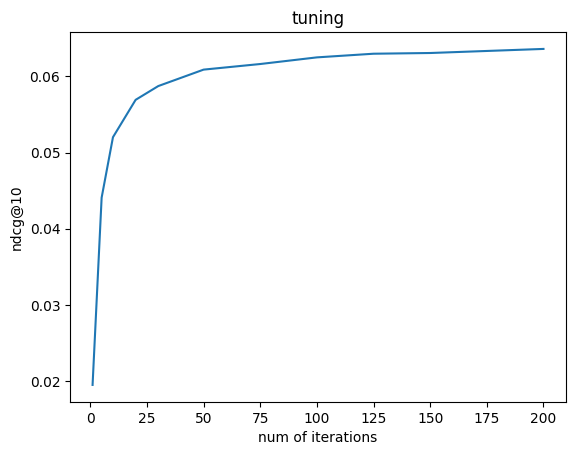

In [16]:
ITERATION_CANDIDATES = [1, 5, 10, 20, 30, 50, 75, 100, 125, 150, 200]
N_REC = 50

from matplotlib import pyplot as plt

results = []
for n_iter in ITERATION_CANDIDATES:
    m = implicit.als.AlternatingLeastSquares(
        factors=128,
        regularization=0.01,
        iterations=n_iter,
        random_state=42,
    )
    m.fit(train_viewable, show_progress=True)
    rec_ids, _ = m.recommend(
        np.arange(train_viewable.shape[0]),
        train_viewable,
        N=N_REC,
        filter_already_liked_items=False,
        recalculate_user=True,
    )
    y_pred = [rec_ids[i].tolist() for i in range(rec_ids.shape[0])]
    ndcg = ndcg_at_k(y_true_train, y_pred, k=10)
    results.append((n_iter, ndcg))
    print(f"  iterations={n_iter} → NDCG@10 (train holdout) = {ndcg:.4f}")

best_iterations = max(results, key=lambda x: x[1])[0]
print(f"Best iterations: {best_iterations}")

# plot the ndcg x number of iterations
plt.plot(np.array(results)[:, 0], np.array(results)[:, 1])
plt.title("tuning")
plt.xlabel("num of iterations")
plt.ylabel("ndcg@10")
plt.show()

50 iterations seem good enough to stabilize the score. More than that takes longer to train for very little gain

In [17]:
# 

# Fit final model with best iteration count (for train/cold-users/cold-artists eval below)
model = implicit.als.AlternatingLeastSquares(
    factors=128,
    regularization=0.01,
    iterations=50,
    random_state=42,
)
model.fit(train_viewable, show_progress=True)


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:11<00:00,  4.43it/s]


In [18]:
metrics_cold_artists2 = evaluate_als_dataset(
    model, val_unseen_artists_viewable, y_true_cold_artists,
    mode="item_inverse", N_REC=N_REC, k_values=K_VALUES,
)
metrics_cold_users2 = evaluate_als_dataset(
    model, val_unseen_users_viewable, y_true_cold_users,
    mode="user", N_REC=N_REC, k_values=K_VALUES,
)
metrics_train2 = evaluate_als_dataset(
    model, train_viewable, y_true_train,
    mode="user", N_REC=N_REC, k_values=K_VALUES,
)

## Report: all scores (3 datasets)

Summary of metrics on **train holdout**, **test: cold users**, and **test: cold artists**.

In [19]:
report = pd.DataFrame({
    "Train holdout": metrics_train2,
    "Test: cold users": metrics_cold_users2,
    "Test: cold artists": metrics_cold_artists2,
})
# Concatenate report and summary1, adding keys to the columns for MultiIndex
report = pd.concat(
    [report, summary1],
    axis=1,
    keys=['tuned iterations', '50 iterations']
)

report.round(4)

tuned iterations                                      \
                Train holdout Test: cold users Test: cold artists   
precision@5            0.0563           0.0955             0.0248   
recall@5               0.0366           0.0634             0.0676   
ndcg@5                 0.0684           0.1052             0.0456   
f1@5                   0.0444           0.0762             0.0363   
map@5                  0.0249           0.0379             0.0266   
precision@10           0.0381           0.0736             0.0213   
recall@10              0.0508           0.0979             0.1169   
ndcg@10                0.0609           0.1028             0.0609   
f1@10                  0.0435           0.0840             0.0361   
map@10                 0.0274           0.0450             0.0336   
precision@20           0.0290           0.0554             0.0166   
recall@20              0.0791           0.1485             0.1783   
ndcg@20                0.0742           0.1273             0.0769   
f1@20                  0.0425           0.0807             0.0303   
map@20                 0.0302           0.0513             0.0382   
mrr                    0.1763           0.2535             0.0660   

             50 iterations                          
                     train cold_users cold_artists  
precision@5         0.0563     0.0955       0.0248  
recall@5            0.0366     0.0634       0.0676  
ndcg@5              0.0684     0.1052       0.0456  
f1@5                0.0444     0.0762       0.0363  
map@5               0.0249     0.0379       0.0266  
precision@10        0.0381     0.0736       0.0213  
recall@10           0.0508     0.0979       0.1169  
ndcg@10             0.0609     0.1028       0.0609  
f1@10               0.0435     0.0840       0.0361  
map@10              0.0274     0.0450       0.0336  
precision@20        0.0290     0.0554       0.0166  
recall@20           0.0791     0.1485       0.1783  
ndcg@20             0.0742     0.1273       0.0769  
f1@20               0.0425     0.0807       0.0303  
map@20              0.0302     0.0513       0.0382  
mrr                 0.1763     0.2535       0.0660